# CS 109A/STAT 121A/AC 209A/CSCI E-109A

## Standard Section 8: Multiclass Model and Midterm Review

**Harvard University**<br/>
**Fall 2017**<br/>
**Section Leaders: Albert Wu, Nathaniel Burbank<br/>**
**Instructors: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine** 

<center>**Download this notebook from the CS109 repo or here:**</center>
<center>**http://bit.ly/109_S8**</center>

This section can be split into two major parts. The first covers multiclass model fitting and is designed to help you get started on HW 7. The second part goes over midterm 2 from 2016 and is designed to help you prepare for the upcoming midterm. 

Specifically, we will: 
    
    1. Use the iris dataset, which we used in section 3, to cover multiclass models and fitting them.
    2. Dive into midterm 2 from last year and go through a thorough review of the solutions that were posted.

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn import preprocessing
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = 500
%matplotlib inline

c:\users\covuworie\.virtualenvs\a-2017-asnab769\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#--------  plot_decision_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (the classifier you want to visualize)
#      title (title for plot)
#      ax (a set of axes to plot on)
#      poly_degree (highest degree of polynomial terms included in the model; None by default)

def plot_decision_boundary(x, y, model, title, ax, poly_degree=None):
    
    # Create mesh
    offset = .1
    # Interval of points for Sepal length
    min0 = x[:,0].min() - offset
    max0 = x[:,0].max() + offset
    interval0 = np.arange(min0, max0, (max0-min0)/300)
    n0 = np.size(interval0)
    
    # Interval of points for Petal width
    min1 = x[:,1].min() - offset
    max1 = x[:,1].max() + offset
    interval1 = np.arange(min1, max1, (max1-min1)/300)
    n1 = np.size(interval1)

    # Create mesh grid of points
    x1, x2 = np.meshgrid(interval0, interval1)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh of points
    # Check if polynomial terms need to be included
    if(poly_degree!=None):
        # Use PolynomialFeatures to generate polynomial terms
        poly = PolynomialFeatures(poly_degree,include_bias = False)
        xx_ = poly.fit_transform(xx)
        yy = model.predict(xx_) 
        
    else:   
        yy = model.predict(xx)
        
    yy = yy.reshape((n0, n1))

    # Plot decision surface
    x1 = x1.reshape(n0, n1)
    x2 = x2.reshape(n0, n1)
    ax.contourf(x1, x2, yy, cmap=plt.cm.coolwarm, alpha=0.1)
    
    # Plot scatter plot of data
    yy = y.reshape(-1,)
    ax.scatter(x[yy==0,0], x[yy==0,1], c='blue', label='Class 0', cmap=plt.cm.coolwarm)
    
    ax.scatter(x[yy==1,0], x[yy==1,1], c='cyan', label='Class 1',cmap=plt.cm.coolwarm)
    
    ax.scatter(x[yy==2,0], x[yy==2,1], c='red', label='Class 2', cmap=plt.cm.coolwarm)
    
    # Label axis, title
    ax.set_title(title)
    ax.legend()
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Petal width')

# Part 0: Fitting Multiclass Models to the Iris Dataset

This first part, part 0, is designed to help you get started on the first part of the homework 7. The dataset we use is similar to that of section 3, where we had flower type as our predictor (0,1,2). Here we will focus on sepal length and petal width as our predictors. We will fit and compare the training and test accuracies of the following classification methods:

- Multiclass Logistic Regression (Multinomial and one-vs-rest (OvR))
- Multiclass Logistic Regression cubic terms
- Linear Discriminant Analysis
- Quadratic Discriminant Analysis
- k-Nearest Neighbors

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/cs109/a-2017/master/Sections/Standard/s8_data/section_8_data.csv')
np.random.seed(seed=109)
msk = np.random.rand(len(df)) < 0.5
data_train_2 = df[msk]
data_test_2 = df[~msk]
data_train_2.head()

,slength,pwidth,target
1,4.9,0.2,0
3,4.6,0.2,0
6,4.6,0.3,0
8,4.4,0.2,0
9,4.9,0.1,0


Let's plot the distribution of each variable and see what we get:

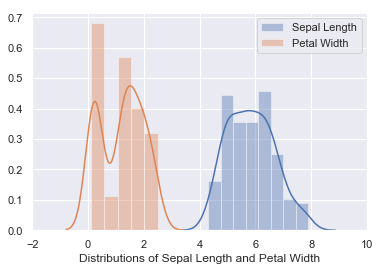

In [4]:
sns.set() # Calling this defaults to regular seaborn plotting, with the gray background.
sns.distplot(df.slength)
sns.distplot(df.pwidth).set(xlabel='Distributions of Sepal Length and Petal Width')
plt.legend(['Sepal Length', 'Petal Width'])
plt.xlim(-2,10);

The column `target` contains our three types of flowers (0,1,2), while `slength` and `pwidth` are the sepal legnth and petal width for each specific flower observation.

Text(0,0.5,'Petal width')

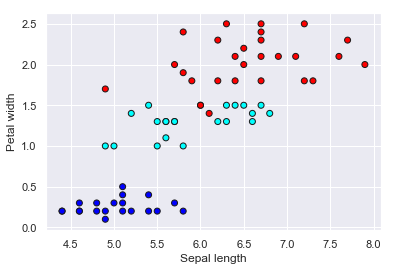

In [5]:
# Plot the training points
colors = ['blue', 'cyan', 'red']
plt.scatter(data_train_2.iloc[:, 0], data_train_2.iloc[:, 1], c=np.array(colors)[data_train_2.iloc[:,2].values], 
            cmap=plt.cm.coolwarm, edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Petal width')

It appears that for our case, a linear classifier will not be able to perfectly separate the points. But it does appear that a linear classifier should seem to do relatively well here. 

Here we will use multinomial logistic regression and one-vs-rest (OvR) logistic regression methods for fitting a multiclass classifier. In OvR, a separate binary classifier is fit for each class, whereas in multinomial logistic regression a single classifier is fit for all classes.

In [6]:
X_train_2 = data_train_2[['slength', 'pwidth']]
y_train_2 = data_train_2['target']
X_test_2 = data_test_2[['slength', 'pwidth']]
y_test_2 = data_test_2['target']

Here, we will fit both a OvR logistic regression and Multinomial logistic regression model. First, we look at the implied decision boundaries from both models on the training set.

In [7]:
logregcv = LogisticRegressionCV(multi_class='ovr')
logregcv.fit(X_train_2, y_train_2)
logregcv_2 = LogisticRegressionCV(multi_class='multinomial')
logregcv_2.fit(X_train_2, y_train_2)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='multinomial', n_jobs=1, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

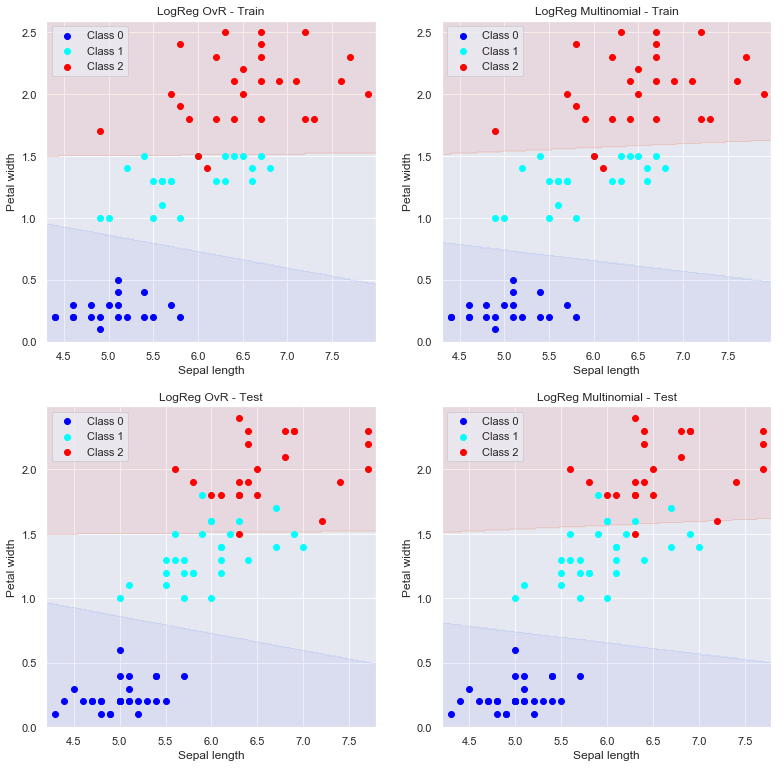

In [8]:
f, axes = plt.subplots(2, 2, figsize = (13,13))

plot_decision_boundary(X_train_2.values, y_train_2.values, 
                               logregcv, "LogReg OvR - Train", axes[0,0])

plot_decision_boundary(X_train_2.values, y_train_2.values, 
                               logregcv_2, "LogReg Multinomial - Train", axes[0,1])

plot_decision_boundary(X_test_2.values, y_test_2.values, 
                               logregcv, "LogReg OvR - Test", axes[1,0])

plot_decision_boundary(X_test_2.values, y_test_2.values, 
                               logregcv_2, "LogReg Multinomial - Test", axes[1,1])

Next we look we look at the training and testing accuracies.

In [9]:
print("Train OvR:", logregcv.score(X_train_2, y_train_2))
print("Test OvR:", logregcv.score(X_test_2, y_test_2))
print("Train Multinomial:", logregcv_2.score(X_train_2, y_train_2))
print("Test Multinomial:",logregcv_2.score(X_test_2, y_test_2))

Train OvR: 0.9710144927536232
Test OvR: 0.9259259259259259
Train Multinomial: 0.9710144927536232
Test Multinomial: 0.9135802469135802


Now, we show how to fit a Multiclass Logistic Regression model with cubic terms:

In [10]:
poly_degree = 3
poly = PolynomialFeatures(poly_degree, include_bias=False)
X_train_poly_cubic = poly.fit_transform(X_train_2)
X_test_poly_cubic = poly.fit_transform(X_test_2)

logregcv_cubic = LogisticRegressionCV()
logregcv_cubic.fit(X_train_poly_cubic, y_train_2)

logregcv_2_poly_cubic = LogisticRegressionCV(multi_class='multinomial')
logregcv_2_poly_cubic.fit(X_train_poly_cubic, y_train_2)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='multinomial', n_jobs=1, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

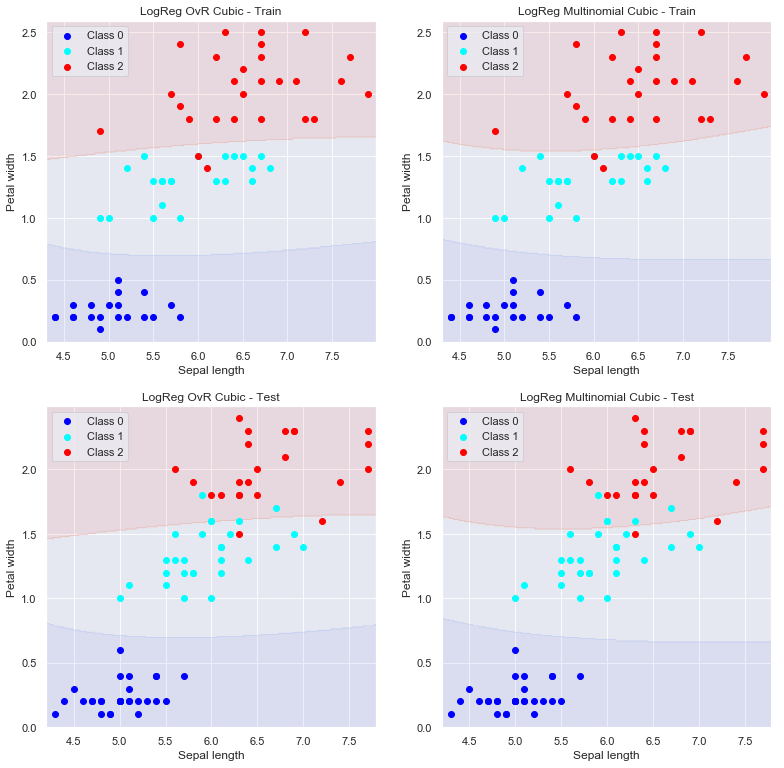

In [11]:
f, axes = plt.subplots(2, 2, figsize = (13,13))

plot_decision_boundary(X_train_poly_cubic, y_train_2.values, 
                               logregcv_cubic, "LogReg OvR Cubic - Train", axes[0,0],poly_degree)

plot_decision_boundary(X_train_poly_cubic, y_train_2.values, 
                               logregcv_2_poly_cubic, "LogReg Multinomial Cubic - Train", axes[0,1],poly_degree)

plot_decision_boundary(X_test_poly_cubic, y_test_2.values, 
                               logregcv_cubic, "LogReg OvR Cubic - Test", axes[1,0],poly_degree)

plot_decision_boundary(X_test_poly_cubic, y_test_2.values,
                               logregcv_2_poly_cubic, "LogReg Multinomial Cubic - Test", axes[1,1],poly_degree)

In [12]:
print("Train LR Cubic Features OvR:", logregcv_cubic.score(X_train_poly_cubic, y_train_2))
print("Test LR Cubic Features OvR:", logregcv_cubic.score(X_test_poly_cubic, y_test_2))
print("Train LR Cubic Features Multinomial:", logregcv_2_poly_cubic.score(X_train_poly_cubic, y_train_2))
print("Test LR Cubic Features Multinomial:",logregcv_2_poly_cubic.score(X_test_poly_cubic, y_test_2))

Train LR Cubic Features OvR: 0.9710144927536232
Test LR Cubic Features OvR: 0.9259259259259259
Train LR Cubic Features Multinomial: 0.9710144927536232
Test LR Cubic Features Multinomial: 0.9135802469135802


We can then compare our results to that given by LDA and QDA:

In [13]:
lda = LDA()
lda.fit(X_train_2, y_train_2)
qda = QDA()
qda.fit(X_train_2, y_train_2)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001)

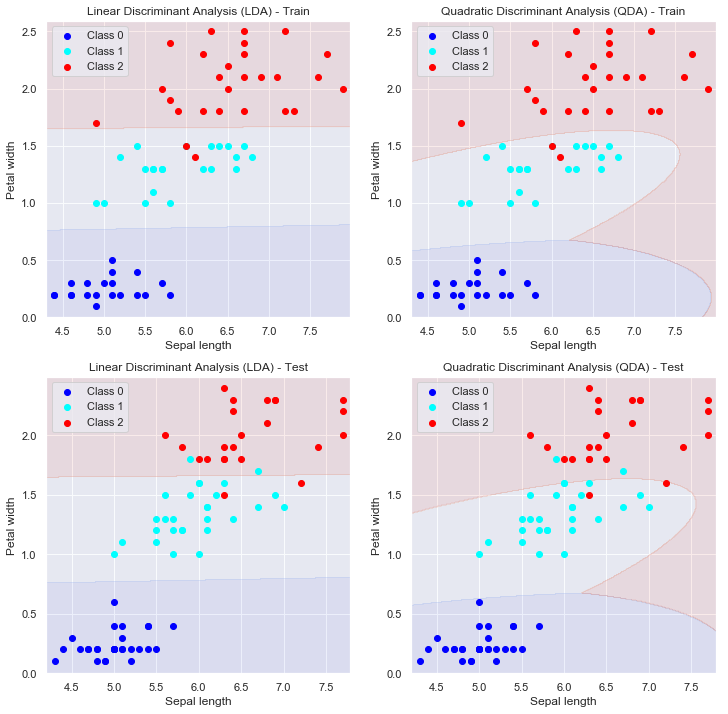

In [14]:
f, axes = plt.subplots(2, 2, figsize = (12,12))

plot_decision_boundary(X_train_2.values, y_train_2.values, 
                               lda, "Linear Discriminant Analysis (LDA) - Train", axes[0,0])

plot_decision_boundary(X_train_2.values, y_train_2.values, 
                               qda, "Quadratic Discriminant Analysis (QDA) - Train", axes[0,1])

plot_decision_boundary(X_test_2.values, y_test_2.values, 
                               lda, "Linear Discriminant Analysis (LDA) - Test", axes[1,0])

plot_decision_boundary(X_test_2.values, y_test_2.values, 
                               qda, "Quadratic Discriminant Analysis (QDA) - Test", axes[1,1])

plt.show()

In [15]:
print("Train LDA:", lda.score(X_train_2, y_train_2))
print("Test LDA:", lda.score(X_test_2, y_test_2))
print("Train QDA:", qda.score(X_train_2, y_train_2))
print("Test QDA:",qda.score(X_test_2, y_test_2))

Train LDA: 0.9710144927536232
Test LDA: 0.9506172839506173
Train QDA: 0.9710144927536232
Test QDA: 0.9259259259259259


Finally, we cover the fitting of k-Nearest Neighbors for $k = 2,5$:

In [16]:
knn_2 = KNN(n_neighbors=2)
knn_2.fit(X_train_2, y_train_2)

knn_5 = KNN(n_neighbors=5)
knn_5.fit(X_train_2, y_train_2)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

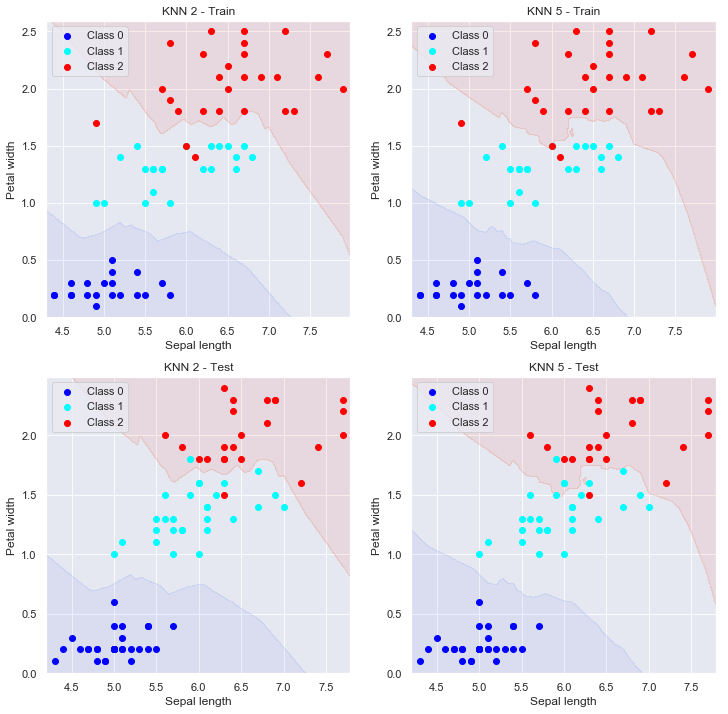

In [17]:
f, axes = plt.subplots(2, 2, figsize = (12,12))

plot_decision_boundary(X_train_2.values, y_train_2.values, 
                               knn_2, "KNN 2 - Train", axes[0,0])

plot_decision_boundary(X_train_2.values, y_train_2.values, 
                               knn_5, "KNN 5 - Train", axes[0,1])

plot_decision_boundary(X_test_2.values, y_test_2.values, 
                               knn_2, "KNN 2 - Test", axes[1,0])

plot_decision_boundary(X_test_2.values, y_test_2.values, 
                               knn_5, "KNN 5 - Test", axes[1,1])
plt.show()

In [18]:
print("Train KNN 2:", knn_2.score(X_train_2, y_train_2))
print("Test KNN 2:", knn_2.score(X_test_2, y_test_2))
print("Train KNN 5:", knn_5.score(X_train_2, y_train_2))
print("Test KNN 5:", knn_5.score(X_test_2, y_test_2))

Train KNN 2: 0.9565217391304348
Test KNN 2: 0.9753086419753086
Train KNN 5: 0.9565217391304348
Test KNN 5: 0.9506172839506173


Complexity of boundaries and memory storage:

Linear logistic = LDA = Decision < QDA = Logistic with quad < kNN

Ease of interpretability:

Decision Tree = Knn < linear logistic/QDA/LDA < logistic with polynomials


### Now we will dive into the last part of HW 7:

In [19]:
cost_func = lambda y_true, y_pred, cost_val: float(  (1000*np.sum(y_pred == 0) + 
                cost_val*np.sum(y_true[y_pred != 0] != y_pred[y_pred != 0]))  )/y_true.shape[0]

In [20]:
logregcv = LogisticRegressionCV(multi_class = 'ovr')
logregcv.fit(X_train_2, y_train_2)
print("Cost of OvR Classifier: ", cost_func(y_test_2, logregcv.predict(X_test_2), 5000))

Cost of OvR Classifier:  740.7407407407408


In [21]:
largest_probs = np.max(logregcv.predict_proba(X_test_2), axis=1)
y_hat = logregcv.predict(X_test_2)
threshold = 0.7
for k, val in enumerate(largest_probs):
    if val < threshold:
        y_hat[k] = 0
print("Cost at cutoff",threshold, ":",cost_func(y_test_2, y_hat, 5000))

Cost at cutoff 0.7 : 617.283950617284


We will now move on to the Midterm 2 solutions from last year:

# Part I: Diagnosing the Simian Flu 2016

You are given the early data for an outbreak of a dangerous virus originating from a group of primates being kept in a Massechussetts biomedical research lab, this virus is dubbed the "Simian Flu".

You have the medical records of $n$ number of patients in `'flu_train.csv`. There are two general types of patients in the data, flu patients and healthy (this is recorded in the column labeled `flu`, a 0 indicates the absences of the virus and a 1 indicates presence). Furthermore, scientists have found that there are two strains of the virus, each requiring a different type of treatment (this is recorded in the column labeled `flutype`, a 1 indicates the absences of the virus, a 2 indicates presence of strain 1 and a 3 indicates the presence of strain 2).

**Your task:** build a model to predict if a given patient has the flu. Your goal is to catch as many flu patients as possible without misdiagnosing too many healthy patients.

**The deliverable:** a function called `flu_predict` which satisfies:

- input: `x_test`, a set of medical predictors for a group of patients
- output: `y_pred`, a set of labels, one for each patient; 0 for healthy and 1 for infected with the flu virus

The MA state government will use your model to diagnose sets of future patients (held by us). You can expect that there will be an increase in the number of flu patients in any groups of patients in the future.

We provide you with some benchmarks for comparison.

**Baseline Model:** 
- ~50% expected accuracy on healthy patients in observed data
- ~50% expected accuracy on flu patients in observed data
- ~50% expected accuracy on healthy patients in future data 
- ~50% expected accuracy on flu patients in future data
- time to build: 5 min

**Reasonable Model:** 
- ~69% expected accuracy on healthy patients in observed data
- ~55% expected accuracy on flu patients, in observed data
- ~69% expected accuracy on healthy patients in future data
- ~60% expected accuracy on flu patients, in future data
- time to build: 20 min

**Grading:**
Your grade will be based on:
1. your model's ability to out-perform our benchmarks
2. your ability to carefully and thoroughly follow the data science pipeline (see lecture slides for definition)
3. the extend to which all choices are reasonable and defensible by methods you have learned in this class

**Solutions:**

## Step 1: Read the data, clean and explore the data


In [22]:
flu_train = pd.read_csv('https://raw.githubusercontent.com/cs109/a-2017/master/Midterms/2016%20Midterm%202/data/flu_train.csv')
flu_test = pd.read_csv('https://raw.githubusercontent.com/cs109/a-2017/master/Midterms/2016%20Midterm%202/data/flu_test.csv')

flu_train.head()

,ID,Gender,Age,AgeDecade,AgeMonths,Race1,Race3,Education,MaritalStatus,HHIncome,HHIncomeMid,Poverty,HomeRooms,HomeOwn,Work,Weight,Length,HeadCirc,Height,BMI,BMICatUnder20yrs,BMI_WHO,Pulse,BPSysAve,BPDiaAve,BPSys1,BPDia1,BPSys2,BPDia2,BPSys3,BPDia3,Testosterone,DirectChol,TotChol,UrineVol1,UrineFlow1,UrineVol2,UrineFlow2,Diabetes,DiabetesAge,HealthGen,DaysMentHlthBad,LittleInterest,Depressed,nPregnancies,nBabies,Age1stBaby,SleepHrsNight,SleepTrouble,PhysActive,PhysActiveDays,TVHrsDay,CompHrsDay,TVHrsDayChild,CompHrsDayChild,Alcohol12PlusYr,AlcoholDay,AlcoholYear,SmokeNow,Smoke100,Smoke100n,SmokeAge,Marijuana,AgeFirstMarij,RegularMarij,AgeRegMarij,HardDrugs,SexEver,SexAge,SexNumPartnLife,SexNumPartYear,SameSex,SexOrientation,PregnantNow,flu,flutype
0,51624,male,34,30-39,409.0,White,NaN,High School,Married,25000-34999,30000.0,1.36,6.0,Own,NotWorking,87.4,NaN,NaN,164.7,32.22,NaN,30.0_plus,70.0,113.0,85.0,114.0,88.0,114.0,88.0,112.0,82.0,NaN,1.29,3.49,352.0,NaN,NaN,NaN,No,NaN,Good,15.0,Most,Several,NaN,NaN,NaN,4.0,Yes,No,NaN,NaN,NaN,NaN,NaN,Yes,NaN,0.0,No,Yes,Smoker,18.0,Yes,17.0,No,NaN,Yes,Yes,16.0,8.0,1.0,No,Heterosexual,NaN,0,1
1,51630,female,49,40-49,596.0,White,NaN,Some College,LivePartner,35000-44999,40000.0,1.91,5.0,Rent,NotWorking,86.7,NaN,NaN,168.4,30.57,NaN,30.0_plus,86.0,112.0,75.0,118.0,82.0,108.0,74.0,116.0,76.0,NaN,1.16,6.70,77.0,0.094,NaN,NaN,No,NaN,Good,10.0,Several,Several,2.0,2.0,27.0,8.0,Yes,No,NaN,NaN,NaN,NaN,NaN,Yes,2.0,20.0,Yes,Yes,Smoker,38.0,Yes,18.0,No,NaN,Yes,Yes,12.0,10.0,1.0,Yes,Heterosexual,NaN,0,1
2,51638,male,9,0-9,115.0,White,NaN,NaN,NaN,75000-99999,87500.0,1.84,6.0,Rent,NaN,29.8,NaN,NaN,133.1,16.82,NaN,12.0_18.5,82.0,86.0,47.0,84.0,50.0,84.0,50.0,88.0,44.0,NaN,1.34,4.86,123.0,1.538,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
3,51646,male,8,0-9,101.0,White,NaN,NaN,NaN,55000-64999,60000.0,2.33,7.0,Own,NaN,35.2,NaN,NaN,130.6,20.64,NaN,18.5_to_24.9,72.0,107.0,37.0,114.0,46.0,108.0,36.0,106.0,38.0,NaN,1.55,4.09,238.0,1.322,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
4,51647,female,45,40-49,541.0,White,NaN,College Grad,Married,75000-99999,87500.0,5.00,6.0,Own,Working,75.7,NaN,NaN,166.7,27.24,NaN,25.0_to_29.9,62.0,118.0,64.0,106.0,62.0,118.0,68.0,118.0,60.0,NaN,2.12,5.82,106.0,1.116,NaN,NaN,No,NaN,Vgood,3.0,None,None,1.0,NaN,NaN,8.0,No,Yes,5.0,NaN,NaN,NaN,NaN,Yes,3.0,52.0,NaN,No,Non-Smoker,NaN,Yes,13.0,No,NaN,No,Yes,13.0,20.0,0.0,Yes,Bisexual,NaN,0,1


In [23]:
flu_train.flu.mean(),flu_test.flu.mean()

(0.05909264201296226, 0.1963470319634703)

So first, only about 6% of the patients have the flu **in our training data**, and in terms of the predictors, we have a mixture of categorical and numerical variables with a fair amount of both missing and semi-duplicate information. To train a model to predict whether new patients will have the flu, we'll have to convert the categorical variables to indicators and handle all of the missing values.

Let's inspect the column types and how many missing values they have:

In [24]:
def column_type(column, df):
    return 'categ' if df[column].dtype == np.dtype('O') else 'numer'

def nan_fraction(column, df):
    return len(df[df[column].isnull()]) * 1. / len(df)

for i, column in enumerate(flu_train.columns):
    if column == 'flu' or column == 'flutype':
        continue
    elif i % 2 == 0:
        print('')
    else:
        print('\t', end='')
    print('{:16} ({}), NaNs: {:.2f}/{:.2f} train/test'.format(
            column, column_type(column, flu_train),
            nan_fraction(column, flu_train),
            nan_fraction(column, flu_test)), end='')


ID               (numer), NaNs: 0.00/0.00 train/test	Gender           (categ), NaNs: 0.00/0.00 train/test
Age              (numer), NaNs: 0.00/0.00 train/test	AgeDecade        (categ), NaNs: 0.04/0.04 train/test
AgeMonths        (numer), NaNs: 0.48/0.46 train/test	Race1            (categ), NaNs: 0.00/0.00 train/test
Race3            (categ), NaNs: 0.52/0.54 train/test	Education        (categ), NaNs: 0.32/0.30 train/test
MaritalStatus    (categ), NaNs: 0.32/0.30 train/test	HHIncome         (categ), NaNs: 0.09/0.09 train/test
HHIncomeMid      (numer), NaNs: 0.09/0.09 train/test	Poverty          (numer), NaNs: 0.08/0.08 train/test
HomeRooms        (numer), NaNs: 0.01/0.01 train/test	HomeOwn          (categ), NaNs: 0.01/0.01 train/test
Work             (categ), NaNs: 0.26/0.25 train/test	Weight           (numer), NaNs: 0.01/0.01 train/test
Length           (numer), NaNs: 0.93/0.93 train/test	HeadCirc         (numer), NaNs: 0.99/0.99 train/test
Height           (numer), NaNs: 0.04/0.04 tra

There are a large number of missing values in the data. Nearly all predictors have some degree of missingness. Some include potentially useful information, while others do not.  NaN in the `'pregnancy'` column is meaningful and informative, as patients with NaN's in the pregnancy column are males, where as NaN's in other predictors may appear randomly. 

As a first pass, we drop any columns with an extremely high fraction of NaNs (along with any other columns that explicitly don't make sense to include, like `ID`). We encode the remaining categorical columns, reserving a separate category for missing values. We do mean imputation on the remaining quantitative variables. 

However, there are many acceptable strategies here, as long as the appropriateness of the method in the context of the task and the data is discussed.

In [25]:
def clean_and_impute(df):
    # don't modify the original frame
    df = df.copy()
    del df['ID']
    del df['AgeMonths'] # almost a duplicate of Age but with more NaNs
    
    for column in df.columns:
        if nan_fraction(column, flu_train) > 0.75:
            print("Dropping {0}".format(column))
            del df[column]
    
    encode = preprocessing.LabelEncoder()

    for column in df.columns:
        if df[column].dtype == np.object:
            df[column] = df[column].fillna('NaN') #Categorical blank values get set as separate category 
            df.loc[:, column] = encode.fit_transform(df[column])
        elif nan_fraction(column, flu_train) > 0:
            df[column+'_missing'] = df[column].isnull().astype(int)
            df[column] = df[column].fillna(flu_train[column].mean()) 
            
    df = df[[c for c in df.columns if c not in ['flu','flutype']] + ['flu','flutype']]
    return df

In [26]:
# Really here clean and impute should be called on the entire dataset
# in case there is a skew in the missing values in train and test set.
# Note we could have dropped different columns in the train and test 
# set here which clearly is not a good idea.
#Clean and encode

train = clean_and_impute(flu_train)
train.head()

Dropping Length
Dropping HeadCirc
Dropping BMICatUnder20yrs
Dropping UrineVol2
Dropping UrineFlow2
Dropping DiabetesAge
Dropping nPregnancies
Dropping nBabies
Dropping Age1stBaby
Dropping TVHrsDayChild
Dropping CompHrsDayChild
Dropping AgeRegMarij
Dropping PregnantNow


,Gender,Age,AgeDecade,Race1,Race3,Education,MaritalStatus,HHIncome,HHIncomeMid,Poverty,HomeRooms,HomeOwn,Work,Weight,Height,BMI,BMI_WHO,Pulse,BPSysAve,BPDiaAve,BPSys1,BPDia1,BPSys2,BPDia2,BPSys3,BPDia3,Testosterone,DirectChol,TotChol,UrineVol1,UrineFlow1,Diabetes,HealthGen,DaysMentHlthBad,LittleInterest,Depressed,SleepHrsNight,SleepTrouble,PhysActive,PhysActiveDays,TVHrsDay,CompHrsDay,Alcohol12PlusYr,AlcoholDay,AlcoholYear,SmokeNow,Smoke100,Smoke100n,SmokeAge,Marijuana,AgeFirstMarij,RegularMarij,HardDrugs,SexEver,SexAge,SexNumPartnLife,SexNumPartYear,SameSex,SexOrientation,HHIncomeMid_missing,Poverty_missing,HomeRooms_missing,Weight_missing,Height_missing,BMI_missing,Pulse_missing,BPSysAve_missing,BPDiaAve_missing,BPSys1_missing,BPDia1_missing,BPSys2_missing,BPDia2_missing,BPSys3_missing,BPDia3_missing,Testosterone_missing,DirectChol_missing,TotChol_missing,UrineVol1_missing,UrineFlow1_missing,DaysMentHlthBad_missing,SleepHrsNight_missing,PhysActiveDays_missing,AlcoholDay_missing,AlcoholYear_missing,SmokeAge_missing,AgeFirstMarij_missing,SexAge_missing,SexNumPartnLife_missing,SexNumPartYear_missing,flu,flutype
0,1,34,3,4,4,3,2,5,30000.0,1.36,6.0,2,2,87.4,164.7,32.22,3,70.0,113.0,85.0,114.0,88.0,114.0,88.0,112.0,82.0,190.980538,1.29,3.49,352.0,0.957834,1,2,15.000000,0,3,4.000000,2,1,3.747683,7,7,2,2.959651,0.000000,1,2,2,18.000000,2,17.000000,1,2,2,16.000000,8.000000,1.000000,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1
1,0,49,4,4,4,5,1,6,40000.0,1.91,5.0,3,2,86.7,168.4,30.57,3,86.0,112.0,75.0,118.0,82.0,108.0,74.0,116.0,76.0,190.980538,1.16,6.70,77.0,0.094000,1,2,10.000000,3,3,8.000000,2,1,3.747683,7,7,2,2.000000,20.000000,2,2,2,38.000000,2,18.000000,1,2,2,12.000000,10.000000,1.000000,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,1,9,0,4,4,4,3,10,87500.0,1.84,6.0,3,1,29.8,133.1,16.82,0,82.0,86.0,47.0,84.0,50.0,84.0,50.0,88.0,44.0,190.980538,1.34,4.86,123.0,1.538000,1,3,3.946268,1,1,6.913895,0,0,3.747683,7,7,0,2.959651,72.353921,0,0,0,17.939148,0,16.983471,0,0,0,17.456042,14.617021,1.354678,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,1
3,1,8,0,4,4,4,3,8,60000.0,2.33,7.0,2,1,35.2,130.6,20.64,1,72.0,107.0,37.0,114.0,46.0,108.0,36.0,106.0,38.0,190.980538,1.55,4.09,238.0,1.322000,1,3,3.946268,1,1,6.913895,0,0,3.747683,7,7,0,2.959651,72.353921,0,0,0,17.939148,0,16.983471,0,0,0,17.456042,14.617021,1.354678,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,1
4,0,45,4,4,4,2,2,10,87500.0,5.00,6.0,2,3,75.7,166.7,27.24,2,62.0,118.0,64.0,106.0,62.0,118.0,68.0,118.0,60.0,190.980538,2.12,5.82,106.0,1.116000,1,5,3.000000,2,2,8.000000,1,2,5.000000,7,7,2,3.000000,52.000000,0,1,1,17.939148,2,13.000000,1,1,2,13.000000,20.000000,0.000000,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [27]:
test = clean_and_impute(flu_test)
test.head()

Dropping Length
Dropping HeadCirc
Dropping BMICatUnder20yrs
Dropping UrineVol2
Dropping UrineFlow2
Dropping DiabetesAge
Dropping nPregnancies
Dropping nBabies
Dropping Age1stBaby
Dropping TVHrsDayChild
Dropping CompHrsDayChild
Dropping AgeRegMarij
Dropping PregnantNow


,Gender,Age,AgeDecade,Race1,Race3,Education,MaritalStatus,HHIncome,HHIncomeMid,Poverty,HomeRooms,HomeOwn,Work,Weight,Height,BMI,BMI_WHO,Pulse,BPSysAve,BPDiaAve,BPSys1,BPDia1,BPSys2,BPDia2,BPSys3,BPDia3,Testosterone,DirectChol,TotChol,UrineVol1,UrineFlow1,Diabetes,HealthGen,DaysMentHlthBad,LittleInterest,Depressed,SleepHrsNight,SleepTrouble,PhysActive,PhysActiveDays,TVHrsDay,CompHrsDay,Alcohol12PlusYr,AlcoholDay,AlcoholYear,SmokeNow,Smoke100,Smoke100n,SmokeAge,Marijuana,AgeFirstMarij,RegularMarij,HardDrugs,SexEver,SexAge,SexNumPartnLife,SexNumPartYear,SameSex,SexOrientation,HHIncomeMid_missing,Poverty_missing,HomeRooms_missing,Weight_missing,Height_missing,BMI_missing,Pulse_missing,BPSysAve_missing,BPDiaAve_missing,BPSys1_missing,BPDia1_missing,BPSys2_missing,BPDia2_missing,BPSys3_missing,BPDia3_missing,Testosterone_missing,DirectChol_missing,TotChol_missing,UrineVol1_missing,UrineFlow1_missing,DaysMentHlthBad_missing,SleepHrsNight_missing,PhysActiveDays_missing,AlcoholDay_missing,AlcoholYear_missing,SmokeAge_missing,AgeFirstMarij_missing,SexAge_missing,SexNumPartnLife_missing,SexNumPartYear_missing,flu,flutype
0,1,4,0,3,4,4,3,4,22500.0,1.07,9.0,2,1,17.0,105.4,15.30,0,73.546618,117.68368,66.554131,118.668882,67.511987,118.036125,66.70936,117.507627,66.311195,190.980538,1.357699,4.835764,117.41557,0.957834,1,3,3.946268,1,1,6.913895,0,0,3.747683,7,7,0,2.959651,72.353921,0,0,0,17.939148,0,16.983471,0,0,0,17.456042,14.617021,1.354678,0,3,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1
1,1,60,6,4,4,3,2,3,17500.0,1.03,5.0,2,3,74.6,169.9,25.84,2,84.000000,152.00000,100.000000,154.000000,98.000000,150.000000,98.00000,154.000000,102.000000,190.980538,1.340000,6.390000,238.00000,0.957834,1,5,0.000000,2,2,6.000000,2,1,3.747683,7,7,2,6.000000,36.000000,1,2,2,16.000000,0,16.983471,0,1,2,20.000000,1.000000,1.354678,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1
2,1,38,3,4,4,5,2,4,22500.0,1.15,6.0,2,3,117.3,180.9,35.84,3,60.000000,147.00000,81.000000,160.000000,84.000000,150.000000,80.00000,144.000000,82.000000,190.980538,0.930000,4.680000,73.00000,0.468000,1,4,4.000000,3,2,5.000000,1,1,3.747683,7,7,1,2.959651,0.000000,0,1,1,17.939148,1,16.983471,1,1,2,23.000000,1.000000,1.000000,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,1,0,0,0,0,1
3,1,8,0,4,4,4,3,9,70000.0,3.55,5.0,2,1,40.1,128.4,24.32,1,76.000000,93.00000,54.000000,86.000000,52.000000,94.000000,56.00000,92.000000,52.000000,190.980538,1.530000,4.140000,124.00000,0.366000,1,3,3.946268,1,1,6.913895,0,0,3.747683,7,7,0,2.959651,72.353921,0,0,0,17.939148,0,16.983471,0,0,0,17.456042,14.617021,1.354678,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,1
4,0,59,5,3,4,0,6,4,22500.0,1.37,4.0,3,2,54.3,145.1,25.79,2,84.000000,150.00000,0.000000,144.000000,0.000000,150.000000,0.00000,150.000000,0.000000,190.980538,1.060000,4.160000,42.00000,0.389000,2,3,3.946268,1,1,5.000000,2,1,3.747683,7,7,0,2.959651,72.353921,0,1,1,17.939148,0,16.983471,0,0,0,17.456042,14.617021,1.354678,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,1,1,1,1,1,1,1,3


In [28]:
#What's up in each set

x = train[[c for c in train.columns if c not in ['flu','flutype']]].values
y = train[['flu']].values.reshape(len(x))

x_test = test[[c for c in train.columns if c not in ['flu','flutype']]].values
y_test = test[['flu']].values.reshape(len(x_test))

print('x train shape:', x.shape)
print('x test shape:', x_test.shape)
print('train class 0: {}, train class 1: {}'.format(len(y[y==0]), len(y[y==1])))
print('train class 0: {}, train class 1: {}'.format(len(y_test[y_test==0]), len(y_test[y_test==1])))

x train shape: (5246, 89)
x test shape: (1533, 89)
train class 0: 4936, train class 1: 310
train class 0: 1232, train class 1: 301


## Step 2: Model Choice

The first task is to decide which, of the large number of classifiers we have learned during this semester, would best suit our task and our data.

It would be possible to do brute force model comparison here - i.e. tune all models and compare which does best with respect to various benchmarks. However, it is also reasonable to do a first round of model comparison by running models (with out of the box parameter settings) on bootstrapped training data and eliminating models which performed very poorly. 

In [29]:
# Expected something interesting to be done with this function in order to 
# calculated expected values and variances. But in fact this method is
# never used
def expected_score(model, x_train, y_train):
    overall = 0
    class_0 = 0
    class_1 = 0
    for i in range(100):
        np.random.seed(i)
        sample = np.random.choice(len(x_train), len(x_train))
        x_sub_train = x_train[sample]
        y_sub_train = y_train[sample]
        
        overall += model.score(x_sub_train, y_sub_train)
        class_0 += model.score(x_sub_train[y_sub_train==0], y_sub_train[y_sub_train==0])
        class_1 += model.score(x_sub_train[y_sub_train==1], y_sub_train[y_sub_train==1])

    return pd.Series([overall / 100., 
                      class_0 / 100.,
                      class_1 / 100.],
                      index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])

score = lambda model, x_train, y_train: pd.Series([model.score(x_train, y_train), 
                                                 model.score(x_train[y_train==0], y_train[y_train==0]),
                                                 model.score(x_train[y_train==1], y_train[y_train==1])], 
                                                index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])

In [30]:
#KNN
knn = KNN(n_neighbors=2)
knn.fit(x, y)

knn_scores = score(knn, x, y)
print('knn')

#Unweighted logistic regression
unweighted_logistic = LogisticRegression(C=1000)
unweighted_logistic.fit(x, y)

unweighted_log_scores = score(unweighted_logistic, x, y)
print('unweighted log')


#Weighted logistic regression
weighted_logistic = LogisticRegression(C=1000, class_weight='balanced')
weighted_logistic.fit(x, y)

weighted_log_scores = score(weighted_logistic, x, y)
print('weighted log')


#LDA
lda = LDA()
lda.fit(x, y)

lda_scores = score(lda, x, y)
print('lda')

#QDA
qda = QDA()
qda.fit(x, y)

qda_scores = score(qda, x, y)
print('qda')

#Decision Tree
tree = DecisionTree(max_depth=50, class_weight='balanced', criterion='entropy')
tree.fit(x, y)

tree_scores = score(tree, x, y)
print('tree')


#Random Forest
rf = RandomForest(class_weight='balanced')
rf.fit(x, y)

rf_scores = score(rf, x, y)

print('rf')

#SVC
svc = SVC(C=100, class_weight='balanced')
svc.fit(x, y)

svc_scores = score(svc, x, y)

print('svc')

knn
unweighted log
weighted log
lda
qda


c:\users\covuworie\.virtualenvs\a-2017-asnab769\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
c:\users\covuworie\.virtualenvs\a-2017-asnab769\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\covuworie\.virtualenvs\a-2017-asnab769\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tree
rf
svc


In [31]:
#Score Dataframe
score_df = pd.DataFrame({'knn': knn_scores, 
                         'unweighted logistic': unweighted_log_scores,
                         'weighted logistic': weighted_log_scores,
                         'lda': lda_scores,
                         'qda': qda_scores,
                         'tree': tree_scores,
                         'rf': rf_scores, 
                         'svc': svc_scores})
score_df

,knn,unweighted logistic,weighted logistic,lda,qda,tree,rf,svc
overall accuracy,0.943195,0.941098,0.704156,0.936332,0.133054,1.0,0.987991,0.999619
accuracy on class 0,1.000000,1.000000,0.705429,0.983590,0.078606,1.0,1.000000,0.999595
accuracy on class 1,0.038710,0.003226,0.683871,0.183871,1.000000,1.0,0.796774,1.000000


It looks like we can rule out KNN, LDA and unweighted logistic. 

**What we do:** We are going to pick weighted logistic regression and just tune the regularization parameter to beat the test benchmarks. Can you figure out why we chose this course of action? Hint: Instead of looking at overall accuracy, look at accuracy on class 1. 

**What's probably good to do:** QDA, random forest, tree, SVC and weighted logistic are beating our train benchmarks as is. We will tune them to beat the test benchmarks by picking the model and parameter set with the highest CV accuracy.

In [32]:
Cs = 10.**np.arange(-3, 4, 1)
scores = []
# Note if we do 20-fold cross-validation then the highest validation set
# accuracy beats the benchmark
n_folds=10
for C in Cs:
    print('C:', C)
    weighted_log_scores = np.array([0., 0., 0.])
    kf = KFold(len(x), n_folds=n_folds, shuffle=True, random_state=10)
    for train_index, test_index in kf:
        x_validate_train, x_validate_test = x[train_index], x[test_index]
        y_validate_train, y_validate_test = y[train_index], y[test_index]

        weighted_logistic = LogisticRegression(C=C, class_weight='balanced')
        weighted_logistic.fit(x_validate_train, y_validate_train)

        weighted_log_scores += score(weighted_logistic, x_validate_test, y_validate_test).values

    scores.append(weighted_log_scores / n_folds) 

scores = pd.DataFrame(np.array(scores).T, columns=[str(C) for C in Cs], index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])

C: 0.001
C: 0.01
C: 0.1
C: 1.0
C: 10.0
C: 100.0
C: 1000.0


**What C means here:** The `C` parameter in the `LogisticRegression` method is the inverse of the regularization parameter $\lambda$. In other words, `C` $= \frac{1}{\lambda}$. As C gets larger, $\lambda$ is getting smaller. Therefore, when we set `C` to be very very large in our earlier homework assignments to make sure there was **no** regularization, this was the same as making $\lambda$ go to zero. When $\lambda$ is zero, there is no regularization applied.

In [33]:
print(scores.T['accuracy on class 1'].max())
scores

0.5775975407578894


,0.001,0.01,0.1,1.0,10.0,100.0,1000.0
overall accuracy,0.717876,0.707200,0.697094,0.69252,0.694614,0.694422,0.692519
accuracy on class 0,0.727051,0.716170,0.705439,0.70083,0.702846,0.703062,0.700577
accuracy on class 1,0.577598,0.568253,0.566487,0.56288,0.566399,0.557396,0.562572


To beat the future benchmark, we'll select the parameter which yields the highest accuracy on class 1 (while still beating the benchmark on class 0).

Now let's test our model on the test data:

In [34]:
#Weighted logistic regression
weighted_logistic = LogisticRegression(C=10, class_weight='balanced')
weighted_logistic.fit(x, y)
weighted_log_scores = score(weighted_logistic, x_test, y_test)
weighted_log_scores

overall accuracy       0.686236
accuracy on class 0    0.706169
accuracy on class 1    0.604651
dtype: float64

Yay, we beat all the benchmarks!

# Part II: Diagnosing Strains of the Simian Flu

From a public health perspective, we want to balance the cost of vaccinations, early interventions and the cost of treating flu complications of unvaccinated people. 

There are two different strains of the flu: strain 1 has a cheaper early intervention as well as a cheaper treatment for flu complications, but patients with strain 1 has a higher rate of developing complications if treated with the wrong intervention. Strain 2 has a more expensive early intervention as well as a more costly treatment for flu complications, but patients with strain 2 has a lower rate of developing complications if treated with the wrong intervention. With no intervention, flu patients develop complications at the same rate regardless of the strain. 

**Your task:** build a model to predict if a given patient has the flu and identify the flu strain. The state government of MA will use your model to inform public health policies: we will vaccinate people you've identified as healthy and apply corresponding interventions to patients with different strains of the flu. We have provided you with a function to compute the total expected cost of this policy decision that takes into account the cost of the vaccine, the interventions and the cost of the treatments for flu complications resulting from misdiagnosing patients. Your goal is to make sure your model produces a public health policy with the lowest associated expected cost.

**The deliverable:** a function called `flu_predict` which satisfies:

- input: `x_test`, a set of medical predictors for a group of patients
- output: `y_pred`, a set of labels, one for each patient; 0 for healthy, 1 for infected with strain 1, and 2 for infected with strain 2.

The MA state government will use your model to diagnose sets of future patients (held by us). You can expect that there will be an increase in the number of flu patients in any groups of patients in the future.

We provide you with some benchmarks for comparison.

**Three Baseline Models:** 
- expected cost on observed data: \$6,818,206, \$7,035,735, \$8,297,197.5
- these values correspond to the all healthy, all 1, and all 2 classifiers, respectively.
- time to build: 1 min

**Reasonable Model:** 
- expected cost on observed data: $6,300,000
- time to build: 20 min

**Grading:**
Your grade will be based on:
1. your model's ability to out-perform our benchmarks
2. your ability to carefully and thoroughly follow the data science pipeline (see lecture slides for definition)
3. the extend to which all choices are reasonable and defensible by methods you have learned in this class

In [35]:
#--------  cost
# A function that computes the expected cost of the public healthy policy based on the 
# classifications generated by your model
# Input: 
#      y_true (true class labels: 0, 1, 2)
#      y_pred (predicted class labels: 0, 1, 2)
# Returns: 
#      total_cost (expected total cost)

def cost(y_true, y_pred):
    cost_of_treatment_1 = 29500
    cost_of_treatment_2 = 45000
    cost_of_intervention_1 = 4150
    cost_of_intervention_2 = 4250
    cost_of_vaccine = 15
    
    prob_complications_untreated = 0.65
    prob_complications_1 = 0.30
    prob_complications_2 = 0.15
    
    trials = 1000    
    
    intervention_cost = cost_of_intervention_1 * len(y_pred[y_pred==1]) + cost_of_intervention_2 * len(y_pred[y_pred==2])

    vaccine_cost = cost_of_vaccine * len(y_pred[y_pred==0])
    
    false_neg_1 = ((y_true == 1) & (y_pred == 2)).sum()
    false_neg_2 = ((y_true == 2) & (y_pred == 1)).sum()
    
    untreated_1 = ((y_true == 1) & (y_pred == 0)).sum()    
    untreated_2 = ((y_true == 2) & (y_pred == 0)).sum()
    
    false_neg_1_cost = np.random.binomial(1, prob_complications_1, (false_neg_1, trials)) * cost_of_treatment_1
    false_neg_2_cost = np.random.binomial(1, prob_complications_2, (false_neg_2, trials)) * cost_of_treatment_2
    untreated_1_cost = np.random.binomial(1, prob_complications_untreated, (untreated_1, trials)) * cost_of_treatment_1
    untreated_2_cost = np.random.binomial(1, prob_complications_untreated, (untreated_2, trials)) * cost_of_treatment_2
    
    false_neg_1_cost = false_neg_1_cost.sum(axis=0)
    expected_false_neg_1_cost = false_neg_1_cost.mean()
    
    false_neg_2_cost = false_neg_2_cost.sum(axis=0)
    expected_false_neg_2_cost = false_neg_2_cost.mean()
    
    untreated_1_cost = untreated_1_cost.sum(axis=0)
    expected_untreated_1_cost = untreated_1_cost.mean()
    
    untreated_2_cost = untreated_2_cost.sum(axis=0)
    expected_untreated_2_cost = untreated_2_cost.mean()
    
    total_cost = vaccine_cost + intervention_cost + expected_false_neg_1_cost + expected_false_neg_2_cost + expected_untreated_1_cost + expected_untreated_2_cost
    
    return total_cost

We're just going to take the weighted logistic model, again, and tune the regularization parameter to both beat the benchmark on the observed data and minimize expected cost on unseen data (i.e. to prevent ***overfitting***). Instead of using 'balanced' class weights, we're using a custom weighting scheme for the three classes (this parameter should really be tuned!).

It would probally also be go through the whole "choosing a model, tuning these models"-process again, this time to minimize cost.

**Note:** Be aware that the cost is now sensitive to sample size! The smaller the pool of patients the less the cost. If you are evaluating cost on a held-out test set then you can artificially make the cost very small. The benchmarks we give are for the test set.

In [36]:
x = train.values[:, :-2]
y = train.values[:, -1]
y = y - 1

x_test = test.values[:, :-2]
y_test = test.values[:, -1]
y_test = y_test - 1

We can take a look at our label frequencies, notice how they are imbalanced.

In [37]:
np.bincount(y.astype(int))/len(y)

array([0.94090736, 0.04327106, 0.01582158])

We'll define a function for computing the accuracy rates so that we can conveniently call it later.

In [38]:
score = lambda model, x_test, y_test: pd.Series([model.score(x_test, y_test), 
                                                 model.score(x_test[y_test==0], y_test[y_test==0]),
                                                 model.score(x_test[y_test==1], y_test[y_test==1]), 
                                                 model.score(x_test[y_test==2], y_test[y_test==2]), 
                                                 cost(y_test, model.predict(x_test))],
                                                index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1', 'accuracy on class 2', 'total cost'])

## Let’s make some benchmarks to compare the cost of our model against...

First, let's cost a perfect model...

In [39]:
l = [('Perfect', cost(y, y), cost(y_test, y_test))] 

print('minimimum cost on train:', cost(y, y))
print('minimimum cost on test:', cost(y_test, y_test))

minimimum cost on train: 1368840.0
minimimum cost on test: 1277630.0


What if we presume that all patients are healthy?

In [40]:
l.append(('All Healthy', cost(y, np.array([0] * len(y))), cost(y_test, np.array([0] * len(y_test)))))

print('simple model cost on train (all 0):', cost(y, np.array([0] * len(y))))
print('simple model cost on test (all 0):', cost(y_test, np.array([0] * len(y_test))))

simple model cost on train (all 0): 6860801.5
simple model cost on test (all 0): 6796092.5


All have strain 1 ... 

In [41]:
l.append(('All 1', cost(y, np.array([1] * len(y))),cost(y_test, np.array([1] * len(y_test)))))

print('simple model cost on train (all 1):', cost(y, np.array([1] * len(y))))
print('simple model cost on test: (all 1):', cost(y_test, np.array([1] * len(y_test))))

simple model cost on train (all 1): 22333985.0
simple model cost on test: (all 1): 7040595.0


All have strain 2 ... 

In [42]:
l.append(('All 2', cost(y, np.array([2] * len(y))),cost(y_test, np.array([2] * len(y_test)))))

print('simple model cost on train (all 2):', cost(y, np.array([2] * len(y))))
print('simple model cost on test (all 2):', cost(y_test, np.array([2] * len(y_test))))

simple model cost on train (all 2): 24307488.5
simple model cost on test (all 2): 8293303.5


In [43]:
pd.DataFrame(l,columns=["Model","Cost on Train (Mil.)","Cost on Test (Mil.)"]).set_index('Model')/10**6

,Cost on Train (Mil.),Cost on Test (Mil.)
Model,,
Perfect,1.368840,1.277630
All Healthy,6.848833,6.786303
All 1,22.334660,7.034025
All 2,24.300055,8.297640


Now let’s cost out the models we trained above…

In [44]:
models = {'knn': knn, 
         'unweighted logistic': unweighted_logistic,
         'weighted logistic': weighted_logistic,
         'lda': lda,
         'qda': qda,
         'tree': tree,
         'rf': rf, 
         'svc': svc}

for k in models:
    print("\n\n**************")
    print(k, "Train")
    mod = models[k]
    mod.fit(x, y)
    scores = score(mod, x, y)
    print(scores.round(decimals=3))
    train_cost = scores['total cost']
    scores = score(mod, x_test, y_test)
    print(k, "Train")
    print(scores.round(decimals=3))
    test_cost = scores['total cost']
    l.append((k,train_cost,test_cost))




**************
knn Train
overall accuracy             0.943
accuracy on class 0          1.000
accuracy on class 1          0.040
accuracy on class 2          0.012
total cost             6652962.000
dtype: float64
knn Train
overall accuracy             0.800
accuracy on class 0          0.995
accuracy on class 1          0.005
accuracy on class 2          0.000
total cost             6767277.500
dtype: float64


**************
unweighted logistic Train
overall accuracy             0.941
accuracy on class 0          1.000
accuracy on class 1          0.004
accuracy on class 2          0.000
total cost             6829913.000
dtype: float64
unweighted logistic Train
overall accuracy             0.803
accuracy on class 0          0.999
accuracy on class 1          0.000
accuracy on class 2          0.000
total cost             6807925.000
dtype: float64


**************
weighted logistic Train
overall accuracy             0.915
accuracy on class 0          0.962
accuracy on class 1    

c:\users\covuworie\.virtualenvs\a-2017-asnab769\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
c:\users\covuworie\.virtualenvs\a-2017-asnab769\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
c:\users\covuworie\.virtualenvs\a-2017-asnab769\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\covuworie\.virtualenvs\a-2017-asnab769\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\covuworie\.virtualenvs\a-2017-asnab769\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


qda Train
overall accuracy             0.192
accuracy on class 0          0.089
accuracy on class 1          0.915
accuracy on class 2          0.000
total cost             6997816.500
dtype: float64


**************
tree Train
overall accuracy             1.0
accuracy on class 0          1.0
accuracy on class 1          1.0
accuracy on class 2          1.0
total cost             1368840.0
dtype: float64
tree Train
overall accuracy             0.765
accuracy on class 0          0.933
accuracy on class 1          0.080
accuracy on class 2          0.070
total cost             6580729.500
dtype: float64


**************
rf Train
overall accuracy             0.990
accuracy on class 0          1.000
accuracy on class 1          0.833
accuracy on class 2          0.795
total cost             2367248.500
dtype: float64
rf Train
overall accuracy             0.803
accuracy on class 0          0.999
accuracy on class 1          0.000
accuracy on class 2          0.000
total cost             680

In [45]:
pd.DataFrame(l,columns=["Model","Cost on Train (Mil.)","Cost on Test (Mil.)"]).set_index('Model')/10**6

,Cost on Train (Mil.),Cost on Test (Mil.)
Model,,
Perfect,1.368840,1.277630
All Healthy,6.848833,6.786303
All 1,22.334660,7.034025
All 2,24.300055,8.297640
knn,6.652962,6.767277
unweighted logistic,6.829913,6.807925
weighted logistic,6.384774,5.920417
lda,6.153555,6.195374
qda,20.550580,6.997816


## Weighted Logistic Reg...

Now let’s see if we can beat our benchmarks…

In [46]:
Cs = 10.**np.arange(-3, 4, 1)
scores = []
n_folds=10
for C in Cs:
    print('C:', C)
    weighted_log_scores = np.array([0., 0., 0., 0., 0.])
    kf = KFold(len(x), n_folds=n_folds, shuffle=True, random_state=10)
    for train_index, test_index in kf:
        x_validate_train, x_validate_test = x[train_index], x[test_index]
        y_validate_train, y_validate_test = y[train_index], y[test_index]

        # interesting heuristic to weight the flu classes as more important
        # than the healthy class
        weighted_logistic = LogisticRegression(C=C, class_weight={0:0.7, 1:10, 2:10})
        weighted_logistic.fit(x_validate_train, y_validate_train)

        weighted_log_scores += score(weighted_logistic, x_validate_test, y_validate_test).values

    scores.append(weighted_log_scores / n_folds)

scores = pd.DataFrame(np.array(scores).T, columns=[str(C) for C in Cs], index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1', 'accuracy on class 2', 'total cost'])

scores

C: 0.001
C: 0.01
C: 0.1
C: 1.0
C: 10.0
C: 100.0
C: 1000.0


,0.001,0.01,0.1,1.0,10.0,100.0,1000.0
overall accuracy,0.933288,0.932334,0.931953,0.933287,0.931763,0.931763,0.931762
accuracy on class 0,0.986395,0.984978,0.984169,0.984793,0.983767,0.983749,0.983978
accuracy on class 1,0.099602,0.098919,0.108443,0.116300,0.113443,0.108681,0.103681
accuracy on class 2,0.068939,0.091558,0.091558,0.108983,0.091558,0.100649,0.099892
total cost,647441.700000,641714.850000,641376.050000,634243.900000,639635.050000,642452.500000,640827.300000


In [47]:
#Weighted logistic regression on training set 
weighted_logistic = LogisticRegression(C=10, class_weight={0:0.7, 1:10, 2:10})
weighted_logistic.fit(x, y)
weighted_log_scores = score(weighted_logistic, x, y)
weighted_log_scores.round(decimals=3)

overall accuracy             0.936
accuracy on class 0          0.986
accuracy on class 1          0.123
accuracy on class 2          0.145
total cost             6210507.500
dtype: float64

In [48]:
#Weighted logistic regression on test set
weighted_log_scores = score(weighted_logistic, x_test, y_test)
weighted_log_scores.round(decimals=3)

overall accuracy             0.806
accuracy on class 0          0.983
accuracy on class 1          0.100
accuracy on class 2          0.050
total cost             6236543.000
dtype: float64

In [49]:
l.append(('Tuned Weighted logistic regression', score(weighted_logistic, x, y)['total cost'],score(weighted_logistic, x_test, y_test)['total cost']))
pd.DataFrame(l,columns=["Model","Cost on Train (Mil.)","Cost on Test (Mil.)"]).set_index('Model')/10**6

,Cost on Train (Mil.),Cost on Test (Mil.)
Model,,
Perfect,1.368840,1.277630
All Healthy,6.848833,6.786303
All 1,22.334660,7.034025
All 2,24.300055,8.297640
knn,6.652962,6.767277
unweighted logistic,6.829913,6.807925
weighted logistic,6.384774,5.920417
lda,6.153555,6.195374
qda,20.550580,6.997816


Yay! We beat the benchmarks on the observed data and did pretty well on test data!